<a href="https://colab.research.google.com/github/chandan2294/Time-Series-with-Deep-Learning-/blob/master/Intro_to_Time_Series_(Basic_Terminology).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, we'll go through some basic terminology which are used in Time Series. We'll be using raw data to understand that.

# **Setup**

In [0]:
#Import all the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

In [0]:
def plot_series(time, series, format = '-', start = 0, end = None, label = None):
  plt.plot(time[start:end], series[start:end], format, label = label)
  plt.xlabel('Time')
  plt.ylabel('Value')
  if label:
    plt.legend(fontsize = 14)
  plt.grid(True)

# Trend and Seasonality

In [0]:
def trend(time, slope = 0):
  return slope * time

Let's create a time series that just trends upward:

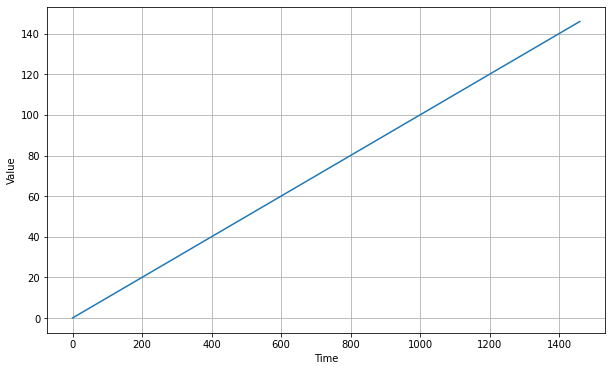

In [9]:
time = np.arange(4 * 365 + 1) #time = ([0, 1, 2, ..., 1458, 1459, 1460]) - Representing 4 years of data
baseline = 10
series = trend(time, 0.1)

plt.figure(figsize = (10, 6))
plot_series(time, series)
plt.show()

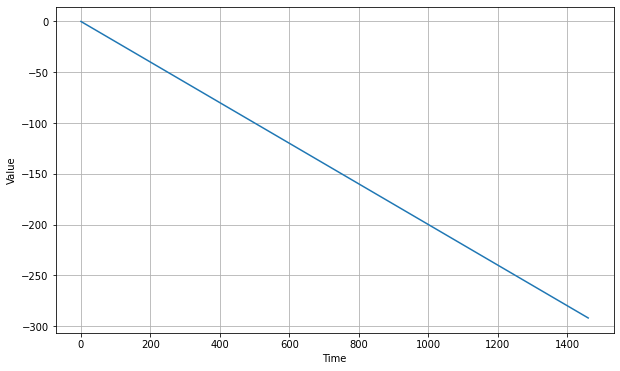

In [10]:
#To demonstrate downward slope

series = trend(time, -0.2)
plt.figure(figsize = (10, 6))
plot_series(time, series)
plt.show()

Now let's generate a time series with a seasonal pattern:

In [0]:
def seasonal_pattern(season_time):
  '''Just an arbitrary pattern, you can change it if you wish'''
  return np.where(season_time < 0.6,
                  np.cos(season_time * 2 * np.pi), 
                  1/np.exp(3 * season_time))

def seasonality(time, period, amplitude = 1, phase = 0):
   """
   Time - data for each day
   Period - Could be yearly(365), weekly(7), day
   Amplitude - Highest point you'd want on y-axis
   Phase - Pattern start point
   Repeats the same pattern at each period
   """
   season_time = ((time + phase) % period)/period
   return amplitude * seasonal_pattern(season_time)

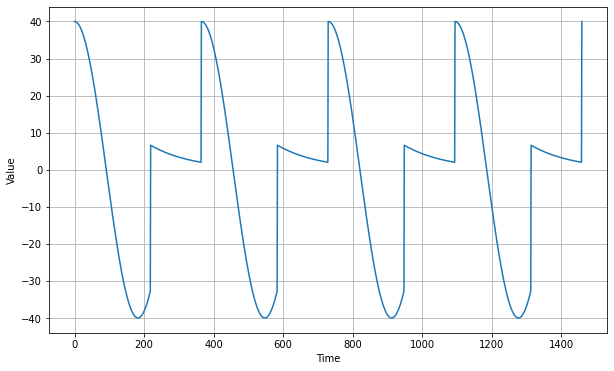

In [43]:
baseline = 10
amplitude = 40
series = seasonality(time, period = 365, amplitude = amplitude)

plt.figure(figsize = (10, 6))
plot_series(time, series)
plt.show()

Now let's create a time series with both trend and seasonality:

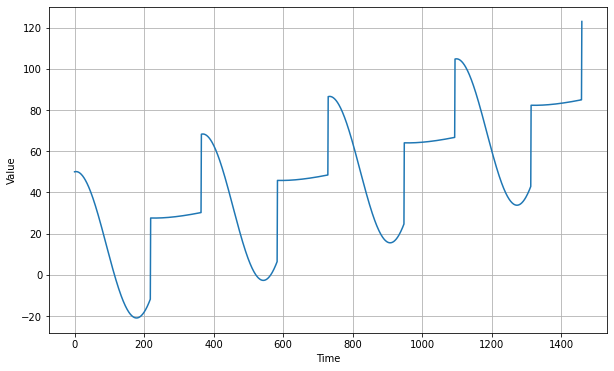

In [44]:
slope = 0.05
series = baseline + trend(time, slope) + seasonality(time, period = 365, amplitude = amplitude)

plt.figure(figsize = (10, 6))
plot_series(time, series)
plt.show()

# Noise

In practice, few real-life time series have such a smooth signal. They usually have some noise, and the signal-to-noise ratio can sometimes be very low. Let's generate some white noise:

In [0]:
def white_noise(time, noise_level = 1, seed = None):
  '''
  noise_level - how large values you need on y-axis
  '''
  rnd = np.random.RandomState(seed)
  return rnd.randn(len(time)) * noise_level

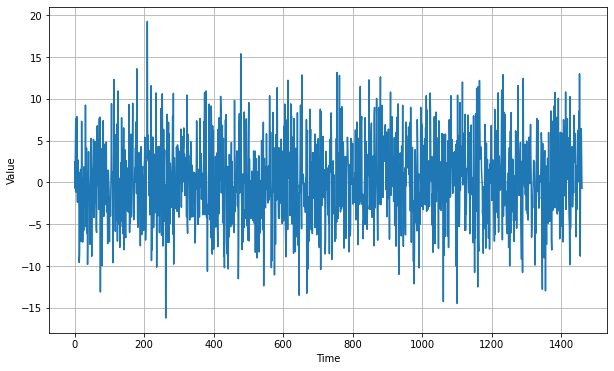

In [48]:
noise_level = 5
noise = white_noise(time, noise_level, seed = 42)

plt.figure(figsize = (10, 6))
plot_series(time, noise)
plt.show()

Now let's add this white noise to the time series:

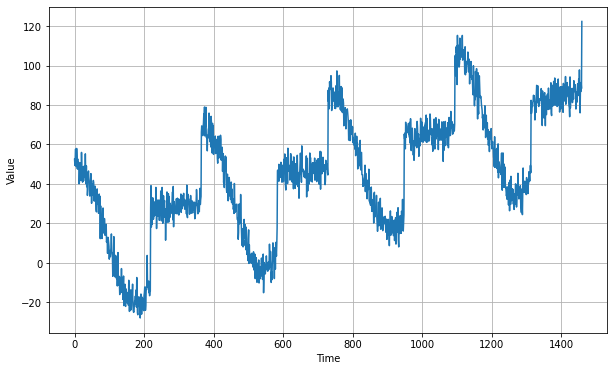

In [53]:
series += noise

plt.figure(figsize = (10, 6))
plot_series(time, series)
plt.show()

All right, this looks realistic enough for now. Let's try to forecast it. We will split it into two periods: the training period and the validation period (in many cases, you would also want to have a test period). The split will be at time step 1000

In [54]:
split_time = 1000
time_train = time[:split_time] #Up to first 1000 instances
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]
print(x_train.shape, x_valid.shape)

(1000,) (461,)


In [0]:
def autocorrelation(time, amplitude, seed = None):
  rnd = np.random.RandomState(seed)
  phi_1 = 0.5
  phi_2 = -0.1
  ar = rnd.randn(len(time) + 50)
  ar[:50] = 100
  for step in range(50, len(time) + 50):
    ar[step] += phi_1 * ar[step - 50]
    ar[step] += phi_2 * ar[step - 33]
  return ar[50:] * amplitude

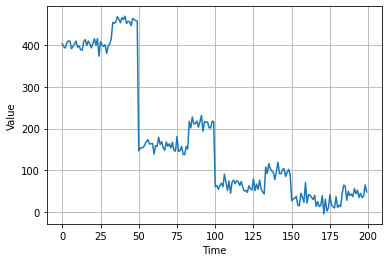

In [56]:
series = autocorrelation(time, 10, seed = 42)
plot_series(time[:200], series[:200])
plt.show()

In [0]:
def autocorrelation(time, amplitude, seed = None):
  rnd = np.random.RandomState(seed)
  phi = 0.8
  ar = rnd.randn(len(time) + 1)
  for step in range(len(time) + 1):
    ar[step] += phi * ar[step - 1]
  return ar[1:] * amplitude

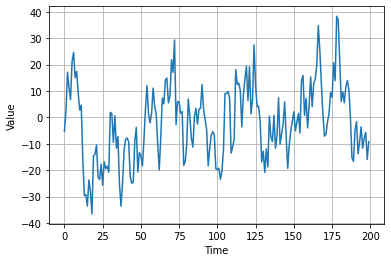

In [58]:
series = autocorrelation(time, 10, seed = 42)
plot_series(time[:200], series[:200])
plt.show()

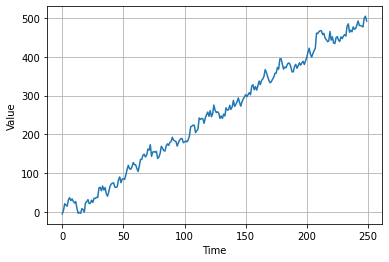

In [59]:
#Let's add trend to it
series = autocorrelation(time, 10, seed = 42) + trend(time, 2)
plot_series(time[:250], series[:250])
plt.show()

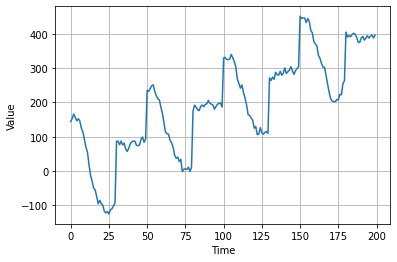

In [60]:
#Now, let's add seasonality to it
series = autocorrelation(time, 10, seed = 42) + seasonality(time, period = 50, amplitude = 150) + trend(time, 2)
plot_series(time[:200], series[:200])
plt.show()

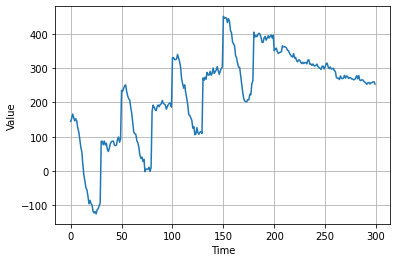

In [64]:
series = autocorrelation(time, 10, seed = 42) + seasonality(time, period = 50, amplitude = 150) + trend(time, 2)
series2 = autocorrelation(time, 5, seed = 42) + seasonality(time, period = 50, amplitude = 2) + trend(time, -1) + 550
series[200:] = series2[200:]
plot_series(time[:300], series[:300])
plt.show()

In [0]:
def impulses(time, num_impulses, amplitude = 1, seed = None):
  rnd = np.random.RandomState(seed)
  impulse_indices = rnd.randint(len(time), size = 10)
  series = np.zeros(len(time))
  for index in impulse_indices:
    series[index] += rnd.rand() * amplitude
  return series

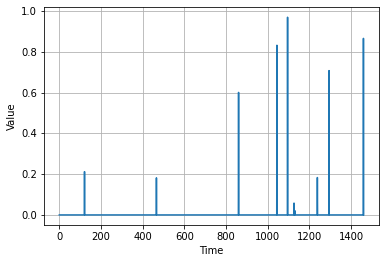

In [66]:
series = impulses(time, 10, seed = 42)
plot_series(time, series)
plt.show()

In [0]:
def autocorrelation(source, phi_s):
  ar = source.copy()
  max_lag = len(phi_s)
  for step, value in enumerate(source):
    for lag, phi in phi_s.items():
      if step - lag > 0:
        ar[step] += phi * ar[step - lag]
  return ar

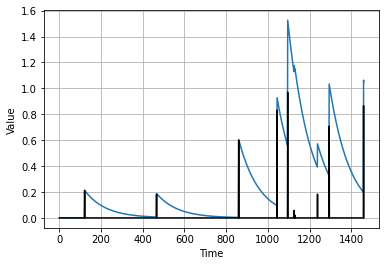

In [68]:
signal = impulses(time, 10, seed = 42)
series = autocorrelation(signal, {1: 0.99})
plot_series(time, series)
plt.plot(time, signal, 'k-')
plt.show()

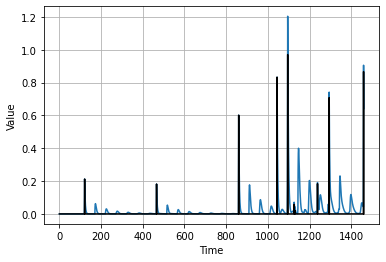

In [70]:
signal = impulses(time, 10, seed = 42)
series = autocorrelation(signal, {1: 0.70, 50: 0.2})
plot_series(time, series)
plt.plot(time, signal, "k-")
plt.show()

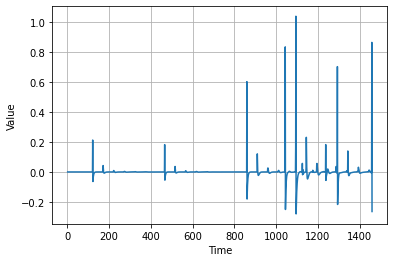

In [71]:
series_diff1 = series[1:] - series[:-1]
plot_series(time[1:], series_diff1)

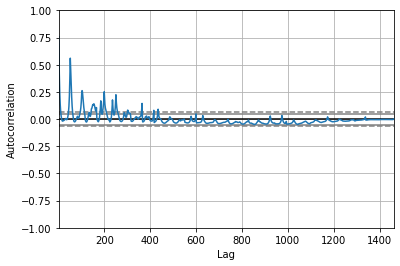

In [72]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(series)